In [1]:
import warnings

warnings.filterwarnings("ignore")

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import plotly.express as px
import random

from scipy.sparse import coo_matrix, csr_matrix, save_npz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm


In [2]:
!pip install LightFM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for LightFM: filename=lightfm-1.17-cp39-cp39-linux_x86_64.whl size=889512 sha256=5d41d7c3a1ad7868d97b5c5dff3a0aa8b49f5d00a1c3e7fb6fa813c118df3da1
  Stored in directory: /root/.cache/pip/wheels/d8/65/93/6ac8180274dc2e8f86ff326be62da1dfa55dc158fd45faba7d
Successfully built LightFM


In [3]:
#!gdown --fuzzy https://drive.google.com/file/d/1zUY4pG_wS0XYFw2qyjpO2_z6_dDA831e/view?usp=share_link
#!unzip retailhero-recommender.zip

In [4]:
!gdown --fuzzy https://drive.google.com/file/d/1hkNnw1F-xLK4-Z95LGB8yDVzjEIQYB1j/view?usp=share_linky

Downloading...
From: https://drive.google.com/uc?id=1hkNnw1F-xLK4-Z95LGB8yDVzjEIQYB1j
To: /content/purchase_small.csv
100% 4.87M/4.87M [00:00<00:00, 46.9MB/s]


In [5]:
data = pd.read_csv("/content/purchase_small.csv")
data.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,20eaa3aef8,1.0,68.0,NaN
1,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,dd18825b63,1.0,70.0,NaN
2,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,c63172f1dc,2.0,36.0,NaN
3,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,44384a83e2,1.0,23.0,NaN
4,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,4f9c1df858,1.0,79.0,NaN


# EDA and preprocessing

In [6]:
data.describe()

,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,product_quantity,trn_sum_from_iss,trn_sum_from_red
count,50000.000000,50000.0000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,3250.000000
mean,7.352530,0.0460,-4.85952,-0.300060,729.334173,1.24518,72.666900,77.029231
std,10.457941,1.9178,32.96727,3.134183,730.718123,1.24511,95.407901,77.708094
min,0.000000,0.0000,-663.00000,-50.000000,1.000000,0.00000,0.000000,0.000000
25%,1.300000,0.0000,0.00000,0.000000,273.410000,1.00000,30.000000,33.000000
50%,2.600000,0.0000,0.00000,0.000000,512.000000,1.00000,50.000000,55.000000
75%,9.700000,0.0000,0.00000,0.000000,916.790000,1.00000,89.000000,94.000000
max,134.500000,100.0000,0.00000,0.000000,8986.400000,133.00000,8072.000000,1099.000000


Lets check for missing values 

In [7]:
for col in data.columns:
    pct_missing = np.mean(data[col].isna())
    if pct_missing >0:
      print('{} - {}%'.format(col, round(pct_missing*100)))

trn_sum_from_red - 94%


In [8]:
data.drop(["trn_sum_from_red"], axis = 1, inplace = True)
data.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss
0,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,20eaa3aef8,1.0,68.0
1,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,dd18825b63,1.0,70.0
2,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,c63172f1dc,2.0,36.0
3,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,44384a83e2,1.0,23.0
4,0007379fdc,12a460f7bd,2018-12-06 08:37:22,2.1,0.0,0.0,0.0,433.24,dea2899dca,4f9c1df858,1.0,79.0


This is columns that have more than 70 percent of non-unique values

In [9]:
num_rows = len(data.index)
low_information_cols = [] 

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.70:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

express_points_received: 99.91000%
0.0      49955
100.0       15
10.0        12
20.0        10
60.0         8
Name: express_points_received, dtype: int64

regular_points_spent: 93.62200%
 0.0      46811
-15.0        93
-7.0         90
-3.0         86
-19.0        85
          ...  
-143.0        2
-50.0         2
-115.0        2
-75.0         2
-96.0         1
Name: regular_points_spent, Length: 160, dtype: int64

express_points_spent: 98.98000%
 0.0     49490
-30.0      355
-50.0       62
-10.0       33
-20.0       31
-6.0        21
-17.0        6
-46.0        1
-29.0        1
Name: express_points_spent, dtype: int64

product_quantity: 75.41200%
1.0      37706
2.0       6681
0.0       3071
3.0       1280
4.0        639
5.0        228
6.0        184
10.0        65
8.0         42
7.0         34
12.0        14
20.0         8
9.0          8
11.0         7
13.0         6
15.0         4
24.0         4
14.0         4
25.0         3
19.0         2
21.0         2
69.0         1
33.0         1


In [10]:
data['ymd'] = data['transaction_datetime'].apply(lambda x: x[:11])
ditrib = data['product_id'].value_counts()[:100].rename_axis('product_id').reset_index(name='counts')
fig = px.bar(ditrib, x="product_id", y="counts", color="counts")
fig.show()
#top clients

Text(0.5, 1.0, 'Purchase per user distribution')

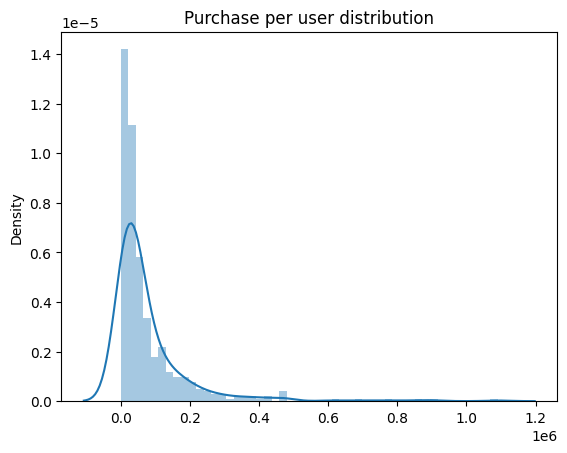

In [11]:
purchase_per_client = data[["client_id","purchase_sum"]].groupby(by = "client_id").sum()
purchase_per_client.head()
sns.distplot(purchase_per_client)
plt.title('Purchase per user distribution')


In [12]:
def filter_by_counts(df: pd.DataFrame, min_product_cnt=10, min_products_per_user=0) -> pd.DataFrame:
    '''
    min_product_cnt - minimum frequency of product_id's purchases among all receipts.
    min_product_ids_per_user - minimum unique product_ids per user.
    '''
    product_id_counts = df.product_id.value_counts()
    product_id_freq = set(product_id_counts[product_id_counts >= int(min_product_cnt)].index)
    df = df[df.product_id.isin(product_id_freq)]
    active_users = dict(data.groupby('client_id')['product_id'].nunique() > min_products_per_user)
    idxs = {k for k, v in active_users.items() if v == True}
    df = df[df.client_id.isin(idxs)]
    return df

In [13]:
data = filter_by_counts(data, min_product_cnt=10, min_products_per_user=0)

In [14]:
def split_by_time(df: pd.DataFrame, split_date="2019-02-18", filter_train=10, filter_test=5):
    '''
    Function splits a data set into train and test by time.

    split_date - date for split 75% train and 25% test.
    filter_train - threshold for minimum number of unique product_ids purchased in train period.
    filter_test - threshold for minimum number of unique product_ids purchased in test period.
    '''
    df.ymd = df.ymd.apply(lambda x: x[:10])
    data_train = df[df.ymd < split_date]
    data_test = df[df.ymd >= split_date]
    
    user_train_cnt = data_train[["client_id", "product_id"]].drop_duplicates().client_id.value_counts()
    train_users = list(user_train_cnt[user_train_cnt >= filter_train].index)
    user_test_cnt = data_test[["client_id", "product_id"]].drop_duplicates().client_id.value_counts()
    test_users = list(user_test_cnt[user_test_cnt >= filter_test].index)

    users_final = set(train_users).intersection(set(test_users))

    data_train = data_train[data_train.client_id.isin(users_final)]
    data_test = data_test[data_test.client_id.isin(users_final)]

    assert data_train.client_id.nunique() == data_test.client_id.nunique()

    return data_train, data_test, list(users_final)

In [15]:
# 75% train 25% test (по времени)
split_date_index = round(3 * data.ymd.nunique() / 4)
split_date = sorted(data.ymd.unique())[split_date_index]

receipts_train, receipts_test, users_final = split_by_time(data,
                                                           split_date=split_date,
                                                           filter_train=10, 
                                                           filter_test=10)

In [16]:
receipts_train.shape, receipts_test.shape

((14385, 13), (6135, 13))

In [17]:
user_encoder, item_encoder = LabelEncoder(), LabelEncoder()
user_encoder.fit(users_final)

all_items = set(receipts_test.product_id.unique()).union(set(receipts_train.product_id.unique()))
item_encoder.fit(list(all_items))

receipts_train['client_new_id'] = user_encoder.transform(receipts_train['client_id'])
receipts_test['client_new_id'] = user_encoder.transform(receipts_test['client_id'])

receipts_train['product_new_id'] = item_encoder.transform(receipts_train['product_id'])
receipts_test['product_new_id'] = item_encoder.transform(receipts_test['product_id'])

matrix_shape = len(user_encoder.classes_), len(item_encoder.classes_)

train_sparse = coo_matrix((list(receipts_train.product_quantity.astype(np.float32)), 
                           (list(receipts_train.client_new_id.astype(np.int64)), 
                            list(receipts_train.product_new_id.astype(np.int64)))), shape=matrix_shape)


test_sparse = coo_matrix((list(receipts_test.product_quantity.astype(np.float32)),
                          (list(receipts_test.client_new_id.astype(np.int64)), 
                           list(receipts_test.product_new_id.astype(np.int64)))), shape=matrix_shape)
train_sparse.shape, test_sparse.shape

((205, 1007), (205, 1007))

# TRAIN

I will build hybrid Recsys using 3 different recommendation models: ALS, LightFM and ... And after collecting all candidates i will use boosting methods for re-ranking.

ALS

In [18]:
!pip install implicit 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 66.3 MB/s eta 0:00:00


In [19]:
from implicit.evaluation import mean_average_precision_at_k

In [20]:
from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=64, regularization=0.05, alpha=2.0)
model.fit(train_sparse)
MAPK = mean_average_precision_at_k(model, train_sparse, test_sparse, K=20)
MAPK

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

0.011016191183225263

In [21]:
from lightfm import LightFM

In [22]:
def metric_lightfm(model, test_sparse, user_features, indices, total, k=20):# проверь мfrom implicit.nearest_neighbours import BM25Recommender

    
    ranks = model.predict_rank(test_sparse, 
                               num_threads=60, 
                               check_intersections=True,
                               user_features=user_features)
    mask = ranks.copy()
    mask.data = np.less(mask.data, k, mask.data)
    ranks.data += 1
    ranks.data = ranks.data * mask.data
    ranks.eliminate_zeros()
    ranks = ranks.tolil().data
    average_precision_sum = 0.0
    for x in indices:
        n_correct_items = 0
        precision = 0
        for y in sorted(ranks[x]):
            n_correct_items += 1
            precision += n_correct_items / y
        average_precision_sum += precision / min(total[x], k)
    average_precision_sum /= len(indices)
    return average_precision_sum

In [23]:
model_lfm_full = LightFM(no_components=100, 
                         loss='warp', 
                         random_state=42, 
                         user_alpha=6e-5, 
                         item_alpha=2e-5, 
                         learning_rate=0.01, 
                         max_sampled=100)

total = test_sparse.getnnz(axis=1)
indices = np.nonzero(total)[0]

maps = []
epochs = 10
rounds = 10
for rounds in tqdm(range(rounds)):
    %time 
    model_lfm_full.fit_partial(train_sparse, 
                               sample_weight=train_sparse, 
                               epochs=epochs, 
                               num_threads=40, 
                               user_features=train_sparse)
    curr_metric = metric_lightfm(model_lfm_full, train_sparse, test_sparse, indices, total, k=20)
    maps.append(curr_metric)
    print(curr_metric)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 9.54 µs


 10%|█         | 1/10 [00:07<01:08,  7.56s/it]

0.019731903489434183
CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.2 µs


 20%|██        | 2/10 [00:13<00:53,  6.68s/it]

0.018973918306148814
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.9 µs


 30%|███       | 3/10 [00:20<00:48,  6.91s/it]

0.01948976415952546
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.2 µs


 40%|████      | 4/10 [00:26<00:38,  6.41s/it]

0.01968886503669266
CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.7 µs


 50%|█████     | 5/10 [00:33<00:32,  6.56s/it]

0.020146585750272054
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 16.2 µs


 60%|██████    | 6/10 [00:38<00:24,  6.19s/it]

0.020308041900254137
CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 12.2 µs


 70%|███████   | 7/10 [00:45<00:19,  6.34s/it]

0.021233526964718287
CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.5 µs


 80%|████████  | 8/10 [00:50<00:12,  6.05s/it]

0.02102175238939529
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


 90%|█████████ | 9/10 [00:56<00:05,  5.96s/it]

0.021407230112711294
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]

0.02142487958961283


In [24]:
def ALS_data(model, train_sparse, test_sparse, top=50):
    
    ALS_dict, ALS_pairs = dict(), list()
    users_test = sorted(list(set(coo_matrix(test_sparse).row)))
    train_sparse = csr_matrix(train_sparse)
    for i in tqdm(range(test_sparse.shape[0])):
        rec_list, rec_set = [], set()
        recommendations = model.recommend(i, train_sparse, N=1000, filter_already_liked_items=False)
        for rank, recom in enumerate(recommendations):
            if recom[1] > 0:
                ALS_dict[(i, recom[0])] = (recom[1], rank + 1)
                if len(rec_list) >= top:
                    break
                elif len(rec_list) < top:
                    rec_list.append((i, recom[0]))
                    rec_set.add(recom[0])
        ALS_pairs.extend(rec_list)
        
    return ALS_dict, ALS_pairs
def lightfm_data(model_lfm, users_test, items_test, top=50):
    
    lightfm_dict, lightfm_pairs = dict(), list()
    user_biases, item_biases = model_lfm.user_biases[users_test], model_lfm.item_biases[items_test]
    
    item_emb = model_lfm.item_embeddings[items_test]
    user_emb = model_lfm.user_embeddings[users_test]
    preds = user_emb.dot(item_emb.T) + user_biases.reshape(-1,1) + item_biases.reshape(1,-1)
    preds_items = (-preds).argsort(axis=1)
    preds_scores = -np.sort(-preds, axis=1)
    items_lfm = dict(list(zip(users_test, preds_items)))
    lfm_scores = dict(list(zip(users_test, preds_scores)))
    
    user_biases_series = pd.Series(user_biases, index=users_test)
    item_biases_series = pd.Series(item_biases, index=items_test)

    for ids, user in tqdm(enumerate(users_test)):
        current_extend = list()
        current_scores = lfm_scores[user]
        
        for rank, (item, value) in enumerate(zip(items_lfm[user], current_scores)):
            if len(current_extend) >= top:
                break
            elif len(current_extend) < top:
                lightfm_dict[(user, item)] =  (value, rank + 1)
                current_extend.append((user, item))                
        lightfm_pairs.extend(current_extend)
        
    user_emb = pd.DataFrame(model_lfm.user_embeddings[users_test], index=users_test)
    
    return lightfm_pairs, lightfm_dict, user_biases_series, item_biases_series, user_emb

In [25]:
ALS_dict, ALS_pairs = ALS_data(model, train_sparse, test_sparse, top=200)

users_test = sorted(list(set(coo_matrix(train_sparse).row)))
items_test = sorted(list(set(train_sparse.col)))

lightfm_pairs, lightfm_dict, user_biases_series, item_biases_series, user_emb = lightfm_data(model_lfm_full, 
                                                                                             users_test, 
                                                                                             items_test, 
                                                                                             top=200)

total_pairs = list(set(ALS_pairs).union(set(lightfm_pairs)))
data_all_pairs = [pair + 
                  ALS_dict.get(pair, (np.nan, np.nan) + 
                  lightfm_dict.get(pair, (np.nan, np.nan))) for pair in tqdm(total_pairs)]
data_all_pairs_df = pd.DataFrame(data_all_pairs, 
                                 columns=["client_id", "product_id", "ALS_score","ALS_rank", "lfm_score", "lfm_rank"])

100%|██████████| 205/205 [00:00<00:00, 1214.15it/s]
205it [00:00, 1749.28it/s]
100%|██████████| 41345/41345 [00:00<00:00, 164150.64it/s]


In [26]:
data_all_pairs_df

,client_id,product_id,ALS_score,ALS_rank,lfm_score,lfm_rank
0,170,560.0,NaN,NaN,3.283149,89.0
1,113,26.0,NaN,NaN,44.792786,2.0
2,100,730.0,NaN,NaN,13.257492,48.0
3,53,160.0,NaN,NaN,0.495701,96.0
4,144,278.0,NaN,NaN,7.488175,68.0
...,...,...,...,...,...,...
41340,39,104.0,NaN,NaN,2.880148,135.0
41341,135,566.0,NaN,NaN,-1.306642,96.0
41342,171,31.0,NaN,NaN,0.351867,188.0
41343,136,976.0,NaN,NaN,6.906328,56.0


In [27]:

import itertools

In [28]:
purchases = list()

for k in tqdm(range(test_sparse.shape[0])):
    test_sparse = csr_matrix(test_sparse)
    cx = scipy.sparse.coo_matrix(test_sparse[k])
    purchased_items, client_id = [], []
    client_id.append(k)
    for i,j,v in zip(cx.row, cx.col, cx.data):
        purchased_items.append(j)
    for i in list(itertools.product(client_id, purchased_items)):
        purchases.append(i)
        
def change_dtype(df):
    df.client_id = df.client_id.astype(np.int32)
    df.product_id = df.product_id.astype(np.int16)
    df.ALS_score = df.ALS_score.astype(np.float32)
    df.ALS_rank = df.ALS_rank.astype(np.float16)
    df.lfm_score = df.lfm_score.astype(np.float32)
    df.lfm_rank = df.lfm_rank.astype(np.float16)
    return df

def purchases2dict(purchases):
    data_true = {}
    for i in tqdm(purchases):
        curr, item = i[0], int(i[1])
        if curr not in data_true:
            data_true[curr] = list()
            data_true[curr].append(item)
        else:
            data_true[curr].append(item)
    for i in tqdm(data_true.keys()):
        data_true[i] = set(data_true[i])
    return data_true

data_all_pairs_df = change_dtype(data_all_pairs_df)
data_true = purchases2dict(purchases)

100%|██████████| 205/205 [00:00<00:00, 353258.96it/s]


In [29]:
%load_ext Cython

In [30]:
%%cython

def average_precision(
        dict data_true,
        dict data_predicted,
        const unsigned long int k
) -> float:
    cdef:
        unsigned long int n_items_predicted
        unsigned long int n_items_true
        unsigned long int n_correct_items
        unsigned long int item_idx

        double average_precision_sum
        double precision

        set items_true
        list items_predicted

    if not data_true:
        raise ValueError('data_true is empty')

    average_precision_sum = 0.0

    for key, items_true in data_true.items():
        items_predicted = data_predicted.get(key, [])

        n_items_true = len(items_true)
        n_items_predicted = min(len(items_predicted), k)

        if n_items_true == 0 or n_items_predicted == 0:
            continue

        n_correct_items = 0
        precision = 0.0

        for item_idx in range(n_items_predicted):
            if items_predicted[item_idx] in items_true:
                n_correct_items += 1
                precision += <double>n_correct_items / <double>(item_idx + 1)

        average_precision_sum += <double>precision / <double>min(n_items_true, k)

    return average_precision_sum / <double>len(data_true)


def metric(true_data, predicted_data, k=20):
    true_data_set = {k: set(v) for k, v in true_data.items()}

    return average_precision(true_data_set, predicted_data, k=k)

In [31]:
def fill_nan(data):
    data.ALS_score.fillna(random.uniform(0, 1), inplace=True)
    data.ALS_rank.fillna(random.randint(200, 300), inplace=True)
    data.lfm_score.fillna(random.uniform(0, 1), inplace=True)
    data.lfm_rank.fillna(random.randint(200, 300), inplace=True)
    return data

predictions = fill_nan(data_all_pairs_df)

In [32]:
items_dict = dict(zip(receipts_train.product_new_id, receipts_train.product_id))
users_dict = dict(zip(receipts_train.client_new_id, receipts_train.client_id))

predictions['client_id'] = predictions['client_id'].map(users_dict)
predictions['product_id'] = predictions['product_id'].map(items_dict)

receipts_test['target'] = 1
dataset = pd.merge(predictions, 
         receipts_test[['client_id', 'product_id', 'target']].drop_duplicates(), 
         how='left',
         left_on=['client_id', 'product_id'], 
         right_on=['client_id', 'product_id'])
dataset['target'].fillna(0, inplace=True)

In [33]:
dataset.target.value_counts(normalize=True)

0.0    0.976394
1.0    0.023606
Name: target, dtype: float64

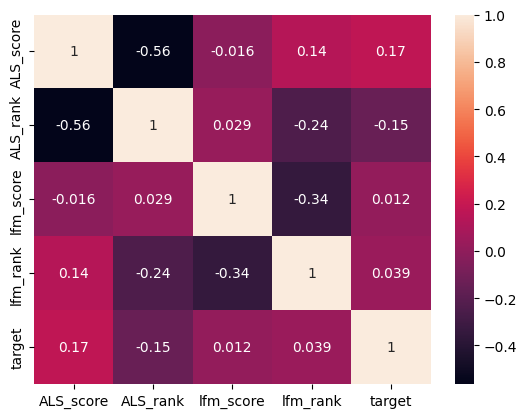

In [34]:
sns.heatmap(dataset.corr(), annot=True);

In [35]:
Y = dataset.pop("target")
X = dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.7, random_state=42)

X_train = x_train[['ALS_score', 'ALS_rank', 'lfm_score','lfm_rank']]
X_test = x_test[['ALS_score', 'ALS_rank', 'lfm_score','lfm_rank']]
train_data, test_data = lightgbm.Dataset(X_train, y_train), lightgbm.Dataset(X_test, y_test)

In [36]:
params = {'objective': 'binary',
          'metric': 'binary_logloss', 
          "num_threads": 20, 
          'verbose': 1, 
          'learning_rate': 4e-4}

model = lightgbm.train(params, 
                       train_data, 
                       valid_sets=test_data, 
                       num_boost_round=5000,
                       early_stopping_rounds=40, 
                       verbose_eval=10)

[LightGBM] [Info] Number of positive: 696, number of negative: 28245
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 539
[LightGBM] [Info] Number of data points in the train set: 28941, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024049 -> initscore=-3.703322
[LightGBM] [Info] Start training from score -3.703322
Training until validation scores don't improve for 40 rounds
[10]	valid_0's binary_logloss: 0.107779
[20]	valid_0's binary_logloss: 0.10763
[30]	valid_0's binary_logloss: 0.107492
[40]	valid_0's binary_logloss: 0.107361
[50]	valid_0's binary_logloss: 0.107239
[60]	valid_0's binary_logloss: 0.107124
[70]	valid_0's binary_logloss: 0.107016
[80]	valid_0's binary_logloss: 0.106912
[90]	valid_0's binary_logloss: 0.106814
[100]	valid_0's binary_

In [37]:
lgb_test = x_test.copy()
lgb_test[['client_id', 'product_id']].drop_duplicates(inplace=True)
lgb_test.set_index(['client_id', 'product_id'], inplace=True)
lgb_test["lgb_score"] = model.predict(lgb_test, num_iteration=model.best_iteration)
lgb_test = lgb_test.set_index('lgb_score', append=True).sort_values("lgb_score", ascending=False)
lgb_test.drop_duplicates(inplace=True)

dataset_predicted = dict()
lgb_test.reset_index(inplace=True)
for user, group in tqdm(lgb_test.groupby("client_id")):
    dataset_predicted[user] = list(group.product_id)[:20]

100%|██████████| 205/205 [00:00<00:00, 8565.09it/s]


In [38]:
lgb_test

,client_id,product_id,lgb_score,ALS_score,ALS_rank,lfm_score,lfm_rank
0,154b74b838,5cb93c9bc5,0.343771,957.000000,1.0,0.186843,244.0
1,1cedf520ab,dc2001d036,0.343771,993.000000,1.0,0.186843,244.0
2,0a612ad272,080ace8748,0.315670,85.000000,1.0,0.186843,244.0
3,15a940afb3,4dcf79043e,0.315670,257.000000,1.0,0.186843,244.0
4,06b50dde09,439498bce2,0.315670,249.000000,1.0,0.186843,244.0
...,...,...,...,...,...,...,...
12369,150ebbb8d9,13298b6c28,0.011012,0.920413,287.0,684.218018,1.0
12370,1588a92031,94f4395269,0.011012,0.920413,287.0,503.748230,1.0
12371,08419395e9,13298b6c28,0.011012,0.920413,287.0,1365.667358,1.0
12372,045fe16a59,d54b19d669,0.011012,0.920413,287.0,377.696564,1.0


In [39]:
def MAPK_LGB(model,test_sparse,k = 20):
  ranks = lgb_test["lgb_score"]

In [40]:
def metric_lightfm(model, test_sparse, user_features, indices, total, k=20):# проверь мfrom implicit.nearest_neighbours import BM25Recommender

    
    ranks = model.predict_rank(test_sparse, 
                               num_threads=60, 
                               check_intersections=True,
                               user_features=user_features)
    mask = ranks.copy()
    mask.data = np.less(mask.data, k, mask.data)
    ranks.data += 1
    ranks.data = ranks.data * mask.data
    ranks.eliminate_zeros()
    ranks = ranks.tolil().data
    average_precision_sum = 0.0
    for x in indices:
        n_correct_items = 0
        precision = 0
        for y in sorted(ranks[x]):
            n_correct_items += 1
            precision += n_correct_items / y
        average_precision_sum += precision / min(total[x], k)
    average_precision_sum /= len(indices)
    return average_precision_sum